In [1]:
%load_ext autoreload
%autoreload 2
# System imports
import copy
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.system.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.system.chip as chip
import c3.signal.pulse as pulse
import c3.system.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils
import examples.two_qubit_chip_exp
import examples.single_qubit_blackbox_exp
import useful

#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

import matplotlib

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution
#tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

True


Setup

In [37]:
#exp = examples.two_qubit_chip_exp.make_exp()
#exp_long = examples.two_qubit_chip_exp.make_exp(0.25e-6)
exp_single = examples.single_qubit_blackbox_exp.create_experiment()
exp_single_long = examples.single_qubit_blackbox_exp.create_experiment(0.25e-6)
#exp_single_long =

Signal Plot & FFT

In [32]:
#import pickle
#pickle.dump(exp_single_fid_values, open( "fidelities_RX90p_23_02_21.p", "wb" ) )
#exp.set_opt_gates(['X90p:Id', 'Id:Id'])

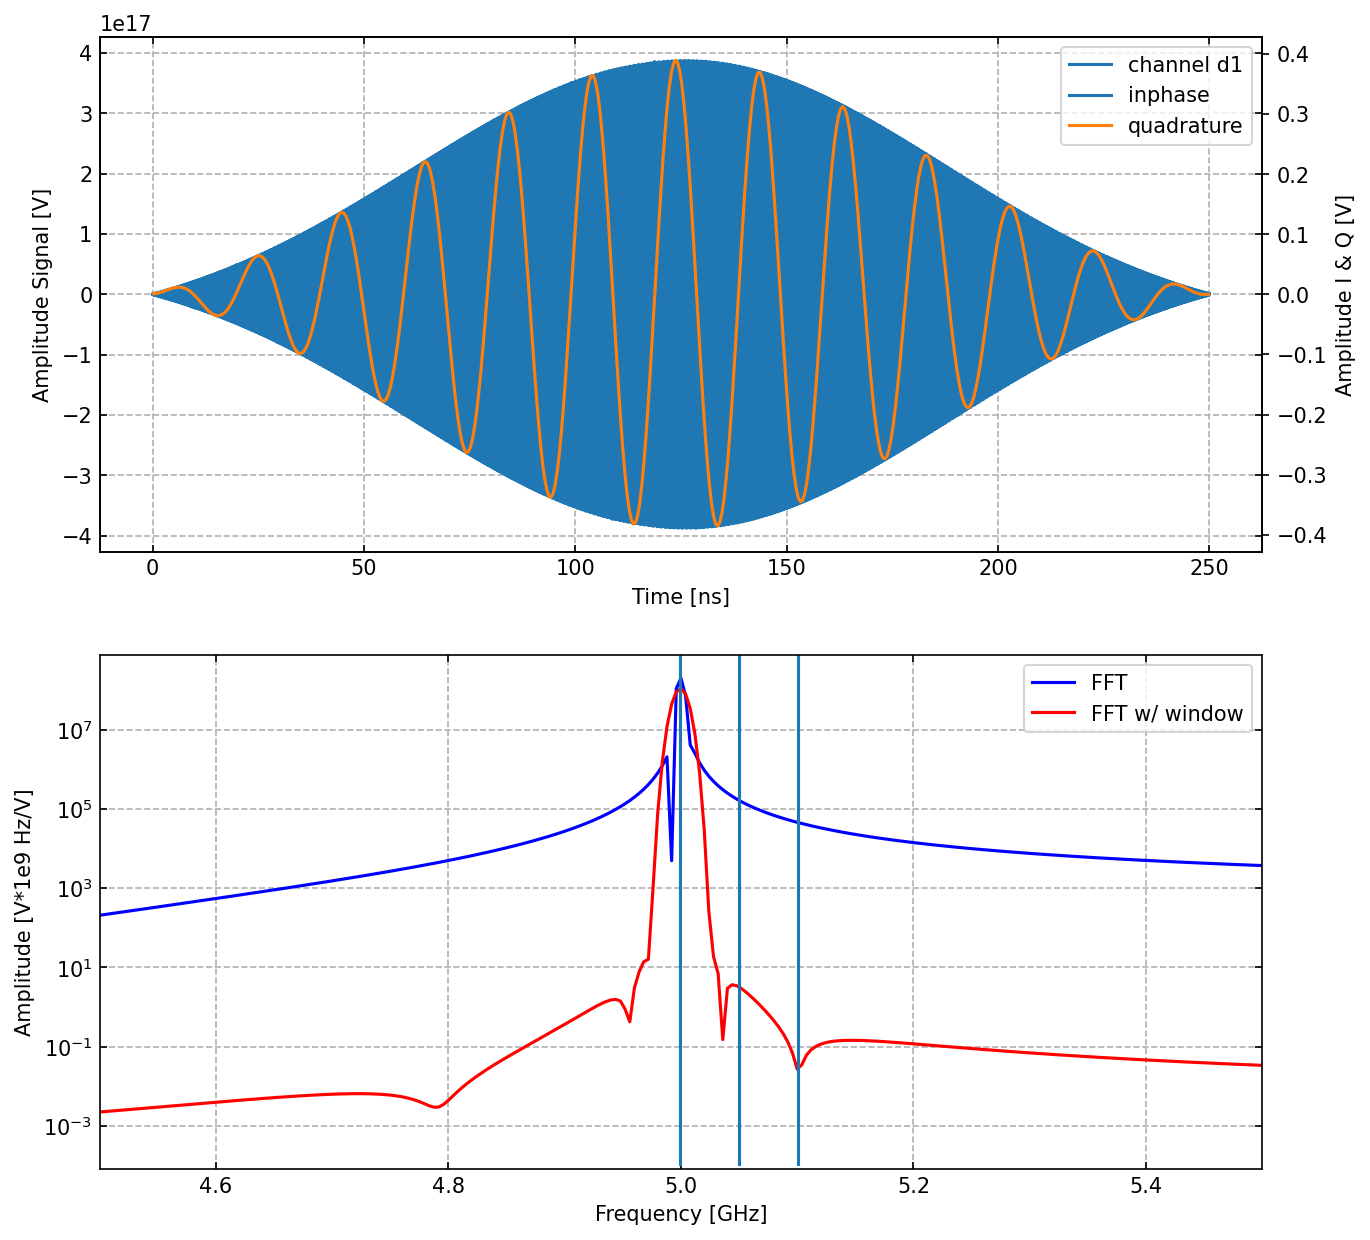

In [4]:
carr_freq = exp_single.pmap.instructions['Id'].comps['d1']['carrier'].params['freq'].numpy()
iq_freq = abs((exp_single.pmap.instructions['RX90p'].comps['d1']['gauss'].params['freq_offset'].get_value()/(2*np.pi)).numpy())
#exp.plot_signal('X90p:Y90p', carr_freq, iq_freq, 'd1')
exp_single_long.plot_signal('RX90p', carr_freq, iq_freq, 'd1')

In [38]:
attr = 'i_offset'
sidebandpeaks = dict()
sidebandpeaks = exp_single_long.measure_fft_peaks('RX90p',carr_freq, iq_freq, 'd1',attr, np.linspace(-0.5, 0.5, 7))

# freq of i and q is (50+3)e6 why is sideband in fft +-2GHz?

Calculating with i_offset: -0.5
Calculating with i_offset: -0.33333333333333337
Calculating with i_offset: -0.16666666666666669
Calculating with i_offset: 0.0
Calculating with i_offset: 0.16666666666666663
Calculating with i_offset: 0.33333333333333326
Calculating with i_offset: 0.5


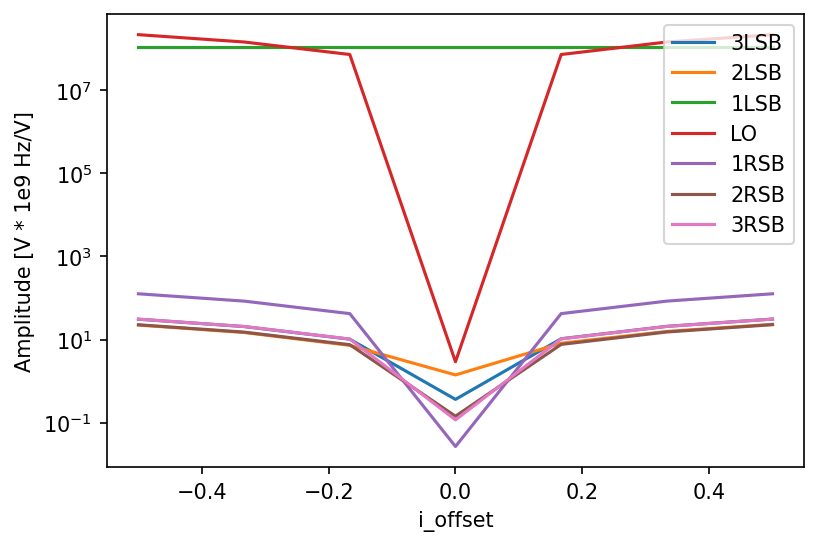

In [53]:
with plt.rc_context({'figure.facecolor': 'white'}):
    fig, ax = plt.subplots(dpi=150)
    for key in sidebandpeaks.keys():
        if key != attr:
            ax.semilogy(sidebandpeaks[attr], sidebandpeaks[key], label=key)
    ax.legend(loc=1)
    ax.set_xlabel(attr)
    ax.set_ylabel('Amplitude [V * 1e9 Hz/V]')
    plt.show()
    fig.savefig('sidebandpwr_over_i_offset.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

Optimize single qubit experiment X pulse with C1 an comprare matrix

In [7]:
#Control values before optimizing

unitaries = exp_single.get_gates()
print(fidelities.unitary_infid(unitaries,'RX90p',[0],[3],False))
#ref_matrix = tf.constant(useful.rx_matrix_3(np.pi/4))


tf.Tensor([0.88887996], shape=(1,), dtype=float64)


In [21]:
exp_single.pmap.generator.devices['AWG'].enable_drag_2()

In [22]:
opt_gates = ["RX90p"]
gateset_opt_map=[
    [
      ("RX90p", "d1", "gauss", "amp"),
    ]
    # ,
    # [
    #   ("RX90p", "d1", "gauss", "freq_offset"),
    # ],
    # [
    #   ("RX90p", "d1", "gauss", "xy_angle"),
    # ],
    # [
    #   ("RX90p", "d1", "gauss", "delta"),
    # ]
    # x90p d1 carrier framechange
]

exp_single.pmap.print_parameters(gateset_opt_map)

RX90p-d1-gauss-amp                    : 450.000 mV 



In [10]:
from c3.optimizers.c1 import C1
import c3.libraries.algorithms as algorithms
import os
import tempfile

In [23]:
# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join('C:\\c3logs')

opt = C1(
    dir_path=log_dir,
    fid_func=fidelities.average_infid_set,
    fid_subspace=["Q1"],
    pmap=exp_single.pmap,
    algorithm=algorithms.lbfgs,
    options={"maxfun" : 10},
    run_name="better_RX90"
)
exp_single.pmap.set_opt_map(gateset_opt_map)
exp_single.set_opt_gates(opt_gates)
opt.set_exp(exp_single)

In [12]:
#opt.optimize_controls()

C3:STATUS:Saving as: C:\c3logs\better_RX90\2021_03_23_T_13_15_09\open_loop.log


In [13]:
opt.current_best_goal

0.001435866571124822

In [24]:
psi_init = [[0] * 3]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

barely_a_seq = ['RX90p']

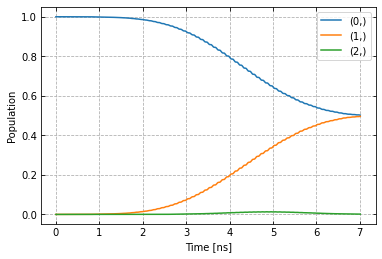

In [15]:
useful.plot_dynamics(exp_single, init_state, barely_a_seq)

In [16]:
unitaries_after_opt = exp_single.get_gates()
#fid_eval = {'afteropt': unitaries_after_opt['X90p'], 'ref': ref_matrix}

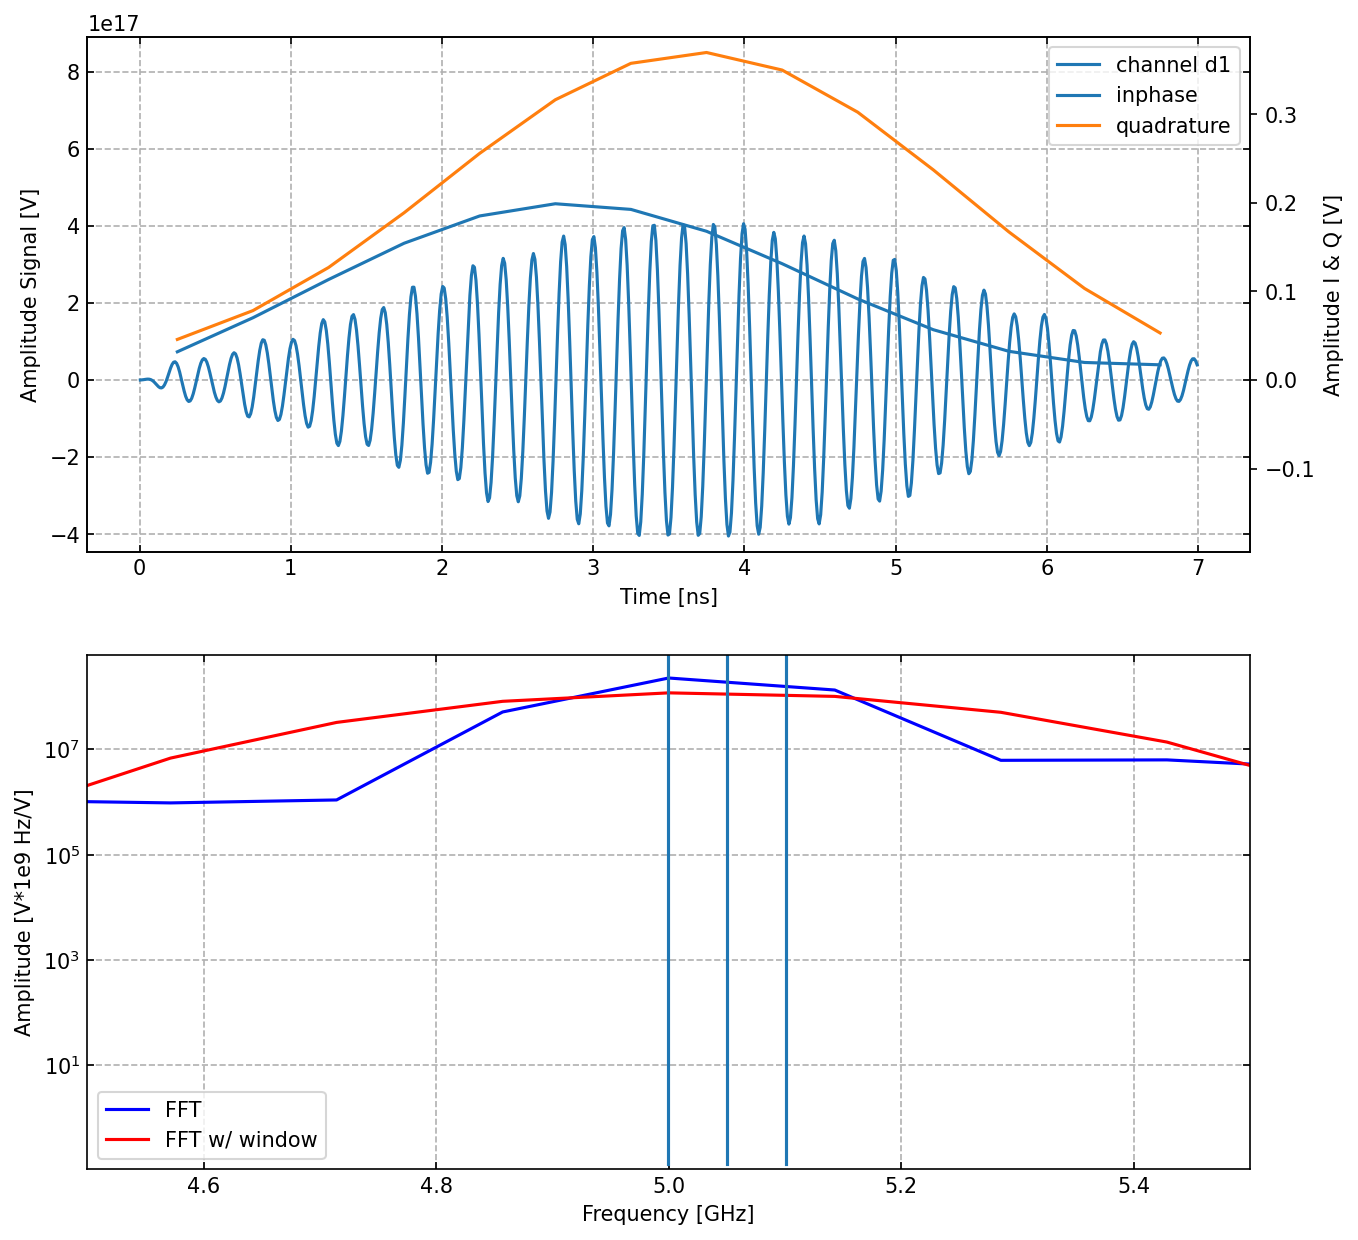

In [17]:
exp_single.plot_signal('RX90p', carr_freq, iq_freq, 'd1')

In [19]:
print(fidelities.unitary_infid(unitaries_after_opt,'RX90p',[0],[3],False).numpy())

exp_single.pmap.print_parameters()

[0.88872059]
RX90p-d1-gauss-amp                    : 456.129 mV 



{
  c3type: AWG
  inputs: 0
  outputs: 1
  params: {}
  resolution: 2000000000.0
  options: drag_2
}
C3:STATUS:Saving as: C:\c3logs\better_RX90\2021_03_23_T_16_02_02\open_loop.log
C3:STATUS:Saving as: C:\c3logs\better_RX90\2021_03_23_T_16_02_07\open_loop.log
C3:STATUS:Saving as: C:\c3logs\better_RX90\2021_03_23_T_16_02_12\open_loop.log
C3:STATUS:Saving as: C:\c3logs\better_RX90\2021_03_23_T_16_02_16\open_loop.log
C3:STATUS:Saving as: C:\c3logs\better_RX90\2021_03_23_T_16_02_21\open_loop.log
C3:STATUS:Saving as: C:\c3logs\better_RX90\2021_03_23_T_16_02_25\open_loop.log
C3:STATUS:Saving as: C:\c3logs\better_RX90\2021_03_23_T_16_02_30\open_loop.log


No handles with labels found to put in legend.


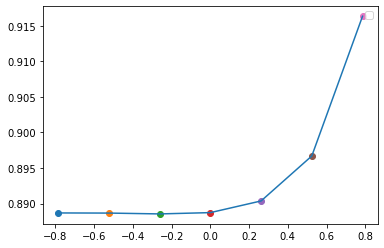

In [33]:
print(exp_single.pmap.generator.devices['AWG'])
exp_single_fid_values = useful.plot_fidelity('RX90p','d1','q_phase_offset',np.linspace(-np.pi/4,np.pi/4,7))

In [ ]:

#print(np.linspace(0.5,1.5,21))

In [ ]:
#useful.plot_fidelity(exp_single,opt,'RX90p','d1','q_factor',np.linspace(0.5,1.5,21))

In [28]:
#import dill

In [30]:
#dill.dump_session('c3test_c3branch.db')

TypeError: cannot pickle '_thread._local' object